In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import astropy
import pickle as p
import glob,os
import astropy.constants as c
import astropy.units as u

In [630]:
import sys
sys.path.insert(0,'../python')
from ath_hst import read_w_pandas as hst_reader

In [22]:
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['font.size']=20
plt.rcParams['font.family']='Sans Serif'
plt.rcParams['lines.linewidth']=2.5
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [23]:
problem_id='MHD_4pc_new'

In [556]:
to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
# taxis is already in units of Myr
t1=200#/to_Myr
t2=500#/to_Myr
t3=545#/to_Myr # time when net mass flux is nearly zero
z1=1000
z2=3000

In [585]:
#labels={'phase3':'warm','phase4':'int','phase5':'hot','all':'whole'}

In [981]:
class data_container(object):
    def __init__(self,pid,base='../data/'):
        zpfname='{}{}.merged.nc'.format(base,pid)
        data=xr.open_dataset(zpfname)
        snfname='{}{}.sn'.format(base,pid)
        self.sn=pa.hst_reader(snfname)

        self.data=self.initial_processing(data)
        self.split_data(self.data)
        self.colors={'warm':'C2','int':'C1','hot':'C3','whole':'C0'}

    def set_units(self,data):
        import astropy.constants as c
        import astropy.units as u
        self.G = c.G.cgs.value
        self.Msun = c.M_sun.cgs.value
        self.pc = c.pc.cgs.value
        self.pi = np.pi
        self.m_unit = 1.4271*c.m_p.cgs.value*pc**3
        self.l_unit = pc
        self.v_unit = 1.e5
        self.t_unit = l_unit/v_unit
        self.G_code = (G/l_unit**3)*m_unit*t_unit**2
        self.rho_unit = m_unit/l_unit**3

        self.p_unit = rho_unit*v_unit**2#m_unit * (1./l_unit) / t_unit/ t_unit
        self.E_unit = p_unit*l_unit**3
        self.deltaz = data.zaxis.data[1]-data.zaxis.data[0]
        self.totarea=float(data['A'].sel(phase='whole')[0,0].data)
        self.dt=np.diff(data.taxis).mean()/to_Myr
        self.kb = c.k_B.cgs.value
        self.to_Myr=(c.pc/(u.km/u.s)).to('Myr').value 
        self.esn = 1.e51/self.E_unit
        self.mej = 10*Msun/self.m_unit
        
    def set_ranges(self,t1=200,t2=500,t3=545,z1=1000,z2=3000):
        # Note taxis is already in units of Myr
        self.t1=t1
        self.t2=t2
        self.t3=t3
        self.z1=z1
        self.z2=z2
        #print(rho_unit, p_unit, pc, deltaz, kb)
        
    def initial_processing(self,data):
                

        self.set_ranges()
        
        t1=self.t1
        t2=self.t2
        t3=self.t3
        
        data=xr.concat([data.sel(taxis=slice(t1,456.)),data.sel(taxis=slice(456.1,t3))],dim='taxis')
        data_sum=data.sum(dim='phase').expand_dims('phase')
        data_sum.coords['phase']=['all']
        data=xr.concat([data,data_sum],dim='phase')
        data.coords['phase']=['cold','unstable','warm','int','hot','whole']
        data['p_flux_kin']=2.0*data['Ek3']
        data['p_flux_mag']=data['PB1']+data['PB2']-data['PB3']
        data['m_flux']=np.sign(data.zaxis)*data['M3']
        data['p_flux']=data['p_flux_kin']+data['p_flux_mag']+data['P']
        data['vz']=data['pFzM3']/data['pFzd']
        data['ekin_flux']=np.sign(data.zaxis)*(data['pFzE1']+data['mFzE1']+data['pFzE2']+data['mFzE2']+data['pFzE3']+data['mFzE3'])
        data['eth_flux']=np.sign(data.zaxis)*(data['pFzP']+data['mFzP'])
        data['e_flux']=data['ekin_flux']+data['eth_flux']
        data['ekin']=data['Ek1']+data['Ek2']+data['Ek3']
        data['eth']=1.5*data['P']
        data['emag']=data['PB1']+data['PB2']+data['PB3']
        data['etot']=data['ekin']+data['eth']+data['emag']
        
        self.set_units(data)
        return data
    
    def split_data(self,data):
        
        t1=self.t1
        t2=self.t2
        t3=self.t3
        z1=self.z1
        z2=self.z2
        
        data_u=data.sel(taxis=slice(t1,t3),zaxis=slice(z1,z2)).isel(phase=slice(2,6))
        data_l=data.sel(taxis=slice(t1,t3),zaxis=slice(-z2,-z1)).isel(phase=slice(2,6))
        data_u.coords['z']=data_u.zaxis
        data_l.coords['z']=data_l.zaxis
        data_l=data_l.reindex({'zaxis':data_l['zaxis'][::-1]})
        data_l.coords['zaxis']=np.abs(data_l.zaxis)
        
        self.data_u=data_u
        self.data_l=data_l
        
    def get_tavg(self,data):

        avg=data.mean(dim='taxis')/self.totarea
        avg['totcool']=self.get_source_term(data['cool'])
        avg['totheat']=self.get_source_term(data['heat'])
        avg['netcool']=avg['totcool']-avg['totheat']
        
        return avg

    def get_flux_diff(self,avg):
        
        z1=self.z1
        z2=self.z2
        deltaz=self.deltaz
        
        avg1=avg.sel(zaxis=z1,method='nearest')
        avg2=avg.sel(zaxis=z2,method='nearest')
        davg=avg-avg1

        davg['Wext']=np.sign(avg.z)*avg['dWext'].cumsum(dim='zaxis')*deltaz
        davg['Wsg']=np.sign(avg.z)*avg['dWsg'].cumsum(dim='zaxis')*deltaz
        davg['W']=davg['Wext']+davg['Wsg']
        davg['m_balance']=davg['m_flux']
        davg['p_balance']=davg['p_flux']+davg['W']
        davg['e_balance']=davg['e_flux']+avg['netcool']

        return davg

    def get_source_term(self,data):
        
        deltaz=self.deltaz
        totarea=self.totarea
        source=data.mean(dim='taxis').cumsum(dim='zaxis')*deltaz/totarea
        source.coords['zaxis']=data.zaxis
        return source

    def get_dt_term(self,data):
        
        t1=self.t1
        t3=self.t3
        deltaz=self.deltaz
        totarea=self.totarea
        
        dq=data.sel(taxis=t3,method='nearest')-data.sel(taxis=t1,method='nearest')
        dt=(t3-t1)/self.to_Myr
        dqdt=dq.cumsum(dim='zaxis')*deltaz/totarea/dt
        dqdt.coords['zaxis']=data.zaxis
        return dqdt

    def get_sn_source_term(self):
        
        z1=self.z1
        z2=self.z2
        deltaz=self.deltaz
        sn=self.sn
        
        zbin=np.arange(z1,z2+deltaz,deltaz)
        sn_select=sn[(sn.time > t1/self.to_Myr) & (sn.time < t3/self.to_Myr)]
        dt=(t3-t1)/self.to_Myr
        NSN_u=np.histogram(sn_select.x3,bins=zbin)
        NSN_l=np.histogram(sn_select.x3,bins=-zbin[::-1])
        nsn_u=NSN_u[0].cumsum()
        nsn_l=NSN_l[0][::-1].cumsum()
        self.esn_u=nsn_u*self.esn/self.totarea/dt
        self.esn_l=nsn_l*self.esn/self.totarea/dt
        self.msn_u=nsn_u*self.mej/self.totarea/dt
        self.msn_l=nsn_l*self.mej/self.totarea/dt

def plot_data(data,colors=None,legend=True,**kwargs):
    if colors is None: colors={'warm':'C2','int':'C1','hot':'C3','whole':'C0'}
    for ph in data.coords['phase'].data:
        plt.plot(data.zaxis,data.sel(phase=ph),color=colors[ph],label=ph,**kwargs)
    if legend: plt.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

In [982]:
dc=data_container(problem_id)

Reading a history file:../data/MHD_4pc_new.sn.p


In [983]:
dc.get_sn_source_term()

# upper side

dqdt_u=dc.get_dt_term(dc.data_u)
avg_u=dc.get_tavg(dc.data_u)
davg_u=dc.get_flux_diff(avg_u)

# lower side

dqdt_l=dc.get_dt_term(dc.data_l)
avg_l=dc.get_tavg(dc.data_l)
davg_l=dc.get_flux_diff(avg_l)

### supplementary figure 

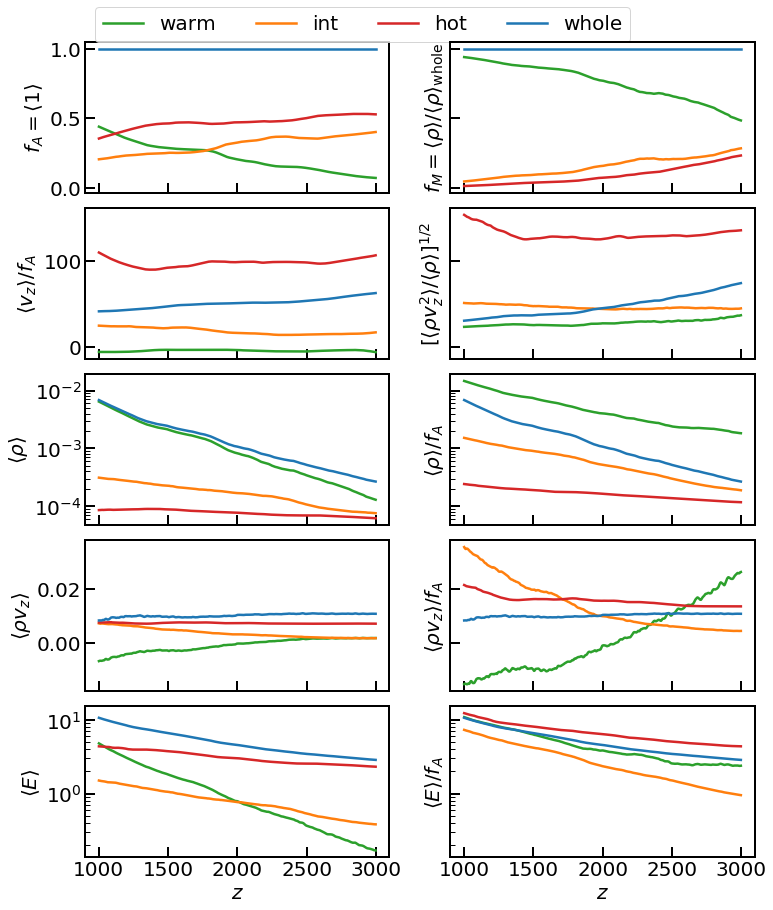

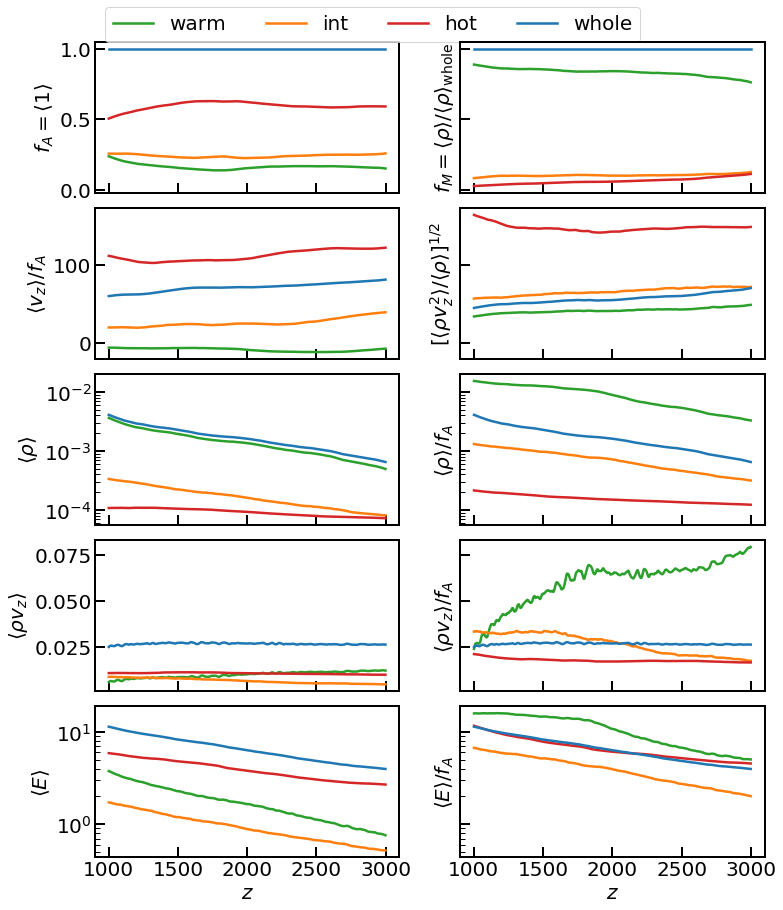

In [1107]:
for avg,side in zip([avg_u,avg_l],['upper','lower']):
    fig,axes = plt.subplots(5,2,sharey='row',sharex=True,figsize=(12,15),
                            gridspec_kw={'wspace':0.2,'hspace':0.1})

    labels=(r'$f_A=\langle 1\rangle$',
            r'$f_M=\langle \rho\rangle/\langle \rho\rangle_{\rm whole}$',
            r'$\langle v_z\rangle/f_A$',
            r'$[\langle \rho v_z^2\rangle/\langle \rho\rangle]^{1/2}$',
            r'$\langle\rho\rangle$',
            r'$\langle\rho\rangle/f_A$',
            r'$\langle\rho v_z\rangle$',
            r'$\langle\rho v_z\rangle/f_A$',
            r'$\langle E\rangle$',
            r'$\langle E\rangle/f_A$',
           )

    for ph in avg.coords['phase'].data:
        fA=avg['A'].sel(phase=ph)
        fM=avg['d'].sel(phase=ph)/avg['d'].sel(phase='whole')
        vz=np.sign(avg.z)*avg['v3'].sel(phase=ph)/fA
        vz2=np.sqrt(2.0*avg['Ek3'].sel(phase=ph)/avg['d'].sel(phase=ph))
        d1=avg['d'].sel(phase=ph)
        d2=d1/fA
        p1=avg['m_flux'].sel(phase=ph)
        p2=p1/fA    
        e1=avg['etot'].sel(phase=ph)
        e2=e1/fA    
        z=avg.zaxis
        plist=[fA,fM,vz,vz2,d1,d2,p1,p2,e1,e2]
        for ax,field,ylabel in zip(axes.flat,plist,labels):
            ax.plot(z,field,color=dc.colors[ph],label=ph)
            ax.set_ylabel(ylabel)
    plt.setp(axes[2,:],'yscale','log')
    plt.setp(axes[4,:],'yscale','log')
    for ax in axes[-1,:]:
        ax.set_xlabel(r'$z$')
    axes[0,0].legend(loc='upper left',bbox_to_anchor=(0.0,1.3),ncol=4)
    fig.savefig('../supplement/profiles_{}.pdf'.format(side),bbox_inches='tight')
    #plt.tight_layout()

# Figure: mass conservation 

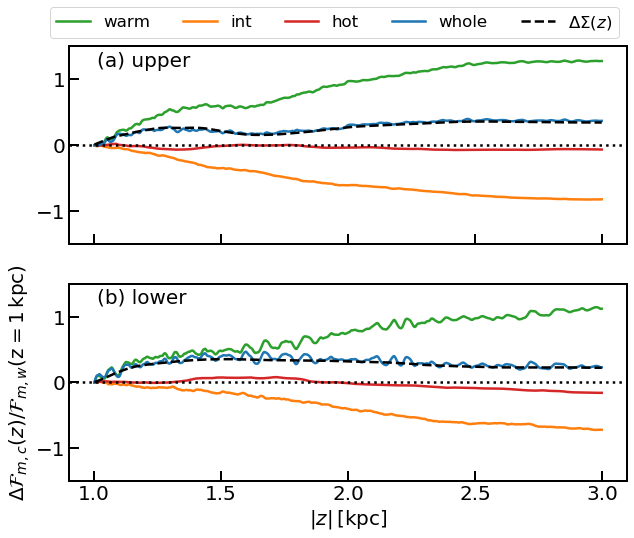

In [1110]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['d'],dqdt_l['d']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['m_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['m_balance'].sel(phase=ph)/ref,color=colors[ph],label=ph)
    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,ls='--',color='k',label=r'$\Delta{\Sigma}(z)$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
axes[1].set_ylabel(r'$\Delta\mathcal{F}_{m,c}(z)/\mathcal{F}_{m,w}({\rm z=1\,kpc})$')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../figures/mass_conservation.pdf',bbox_inches='tight')

# Figure: momentum conservation

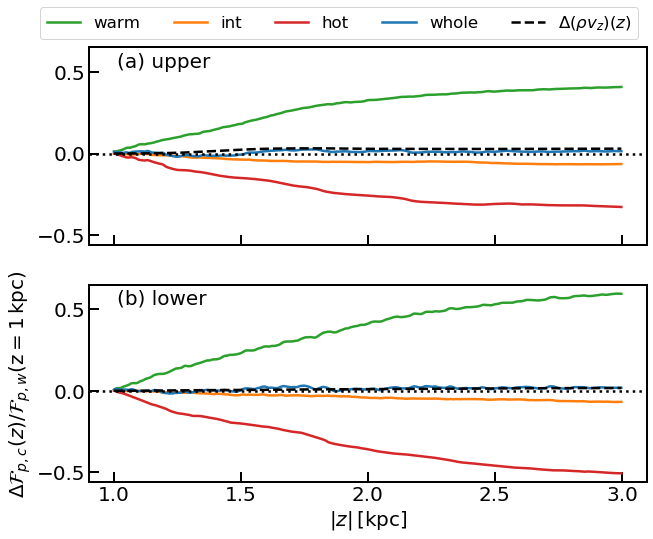

In [1109]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,mdot,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],[dqdt_u['m_flux'],dqdt_l['m_flux']],axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['p_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['p_balance'].sel(phase=ph)/ref,color=colors[ph],label=ph)
    ax.plot(dqdt_u.zaxis/1.e3,-mdot.sel(phase='whole')/ref,ls='--',color='k',label=r'$\Delta(\rho v_z)(z)$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    #ax.set_ylim(-0.7,0.7)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
axes[1].set_ylabel(r'$\Delta\mathcal{F}_{p,c}(z)/\mathcal{F}_{p,w}({\rm z=1\,kpc})$')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../figures/momentum_conservation.pdf',bbox_inches='tight')

# Figure: energy conservation

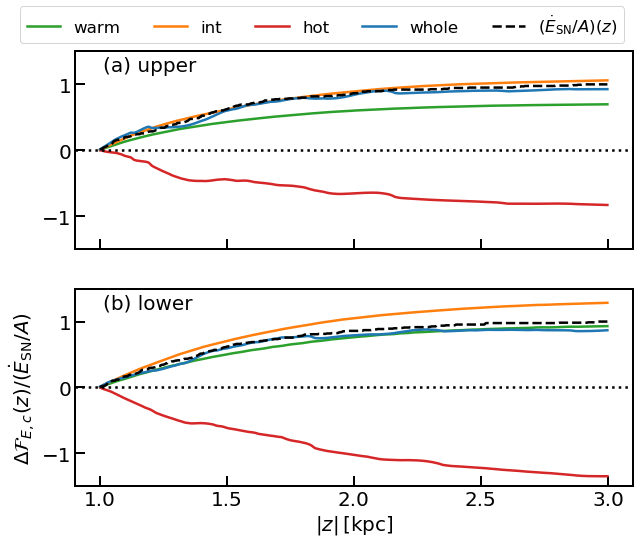

In [1115]:
fig,axes = plt.subplots(2,1,sharey=True,sharex='col',figsize=(10,8))
for avg,davg,esn,ax,label in zip([avg_u,avg_l],[davg_u,davg_l],
                                  [dc.esn_u,dc.esn_l],
                                  axes,['(a) upper','(b) lower']):
    ref=np.abs(avg['e_flux'].sel(zaxis=dc.z1,method='nearest').sel(phase='warm'))
    ref=esn[-1]
    for ph in davg.coords['phase'].data:
        ax.plot(davg.zaxis/1.e3,davg['e_balance'].sel(phase=ph)/ref,color=colors[ph],label=ph)
    ax.plot(dqdt_u.zaxis/1.e3,esn/ref,ls='--',color='k',label=r'$(\dot{E}_{\rm SN}/A)(z)$')
    ax.axhline(0,ls=':',color='k')
    ax.text(0.05,0.9,label,transform=ax.transAxes)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([1,1.5,2,2.5,3])
#plt.plot(dqdt_u.zaxis,dc.msn_u,ls='--')
axes[1].set_ylabel(r'$\Delta\mathcal{F}_{E,c}(z)/(\dot{E}_{\rm SN}/A)$')
axes[1].set_xlabel(r'$|z|\,[{\rm kpc}]$')
axes[0].legend(loc='lower right',bbox_to_anchor=(1.0,1.0),ncol=5,fontsize='small')
fig.savefig('../figures/energy_conservation.pdf',bbox_inches='tight')

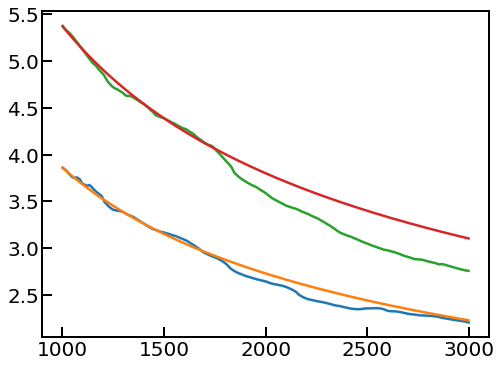

In [1097]:
for avg in [avg_u,avg_l]:
    plt.plot(avg.zaxis,avg['p_flux'].sel(phase='hot'))
    plt.plot(avg.zaxis,avg['p_flux'].sel(phase='hot')[0]/(avg.zaxis/1.e3)**(0.5))

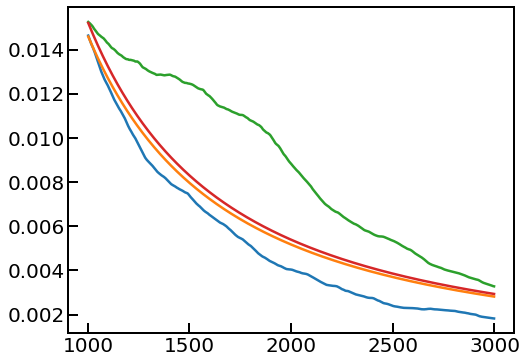

In [1106]:
for avg in [avg_u,avg_l]:
    plt.plot(avg.zaxis,avg['d'].sel(phase='warm')/avg['A'].sel(phase='warm'))
    plt.plot(avg.zaxis,(avg['d'].sel(phase='warm')/avg['A'].sel(phase='warm'))[0]/(avg.zaxis/1.e3)**(1.5))

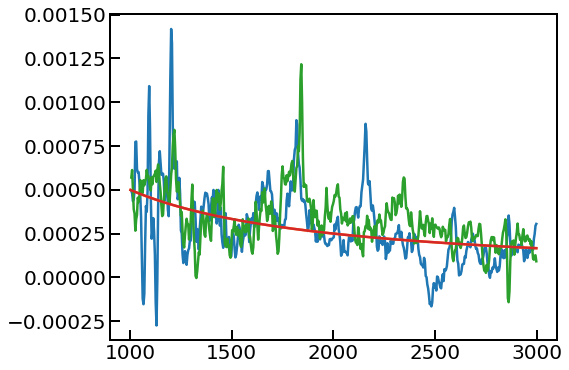

In [1101]:
for avg in [avg_u,avg_l]:
    lnF=np.log(avg['p_flux'].sel(phase='hot'))

    dlnFdz=-np.diff(lnF)/deltaz

    z0=1.e3
    z=avg.zaxis
    plt.plot(avg.zaxis[1:],dlnFdz)
    plt.plot(avg.zaxis,(z0/z)/(2*z0))


In [1074]:
fA=avg['A'].sel(phase='warm')

(0, 1000.0)

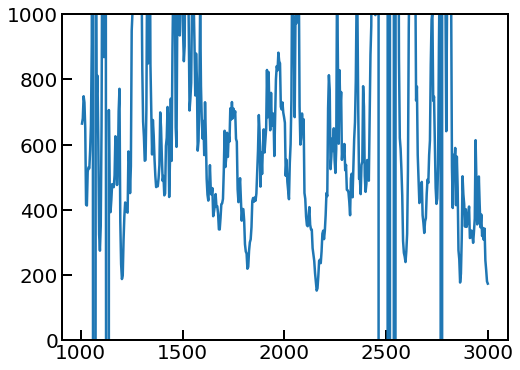

In [1078]:
plt.plot(avg.zaxis[1:],3./4.*fA[1:]/dlnFdz)
plt.ylim(0,1.e3)

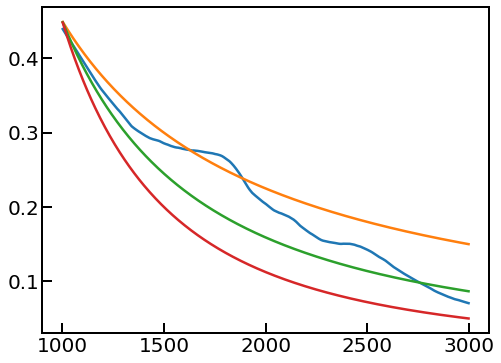

In [1070]:
plt.plot(avg.zaxis,fA)
plt.plot(avg.zaxis,0.45/(avg.zaxis/1.e3)**1)
plt.plot(avg.zaxis,0.45/(avg.zaxis/1.e3)**1.5)
plt.plot(avg.zaxis,0.45/(avg.zaxis/1.e3)**2)

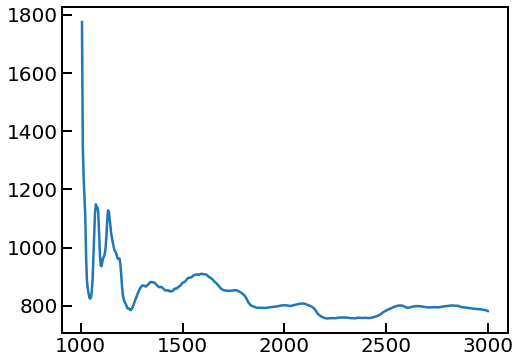

In [1054]:
plt.plot(avg.zaxis,1/(lnF/(fA.cumsum(dim='zaxis')*deltaz)))

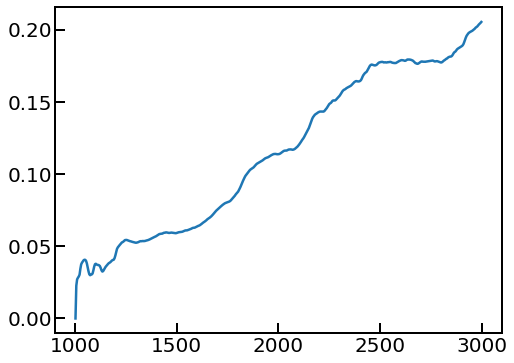

In [1036]:
avg=avg_u
davg=davg_u
dlnFdz=(davg['p_flux']/(z1-davg.zaxis)/avg['p_flux']).sel(phase='hot')
nw=(avg['d']/avg['A']).sel(phase='warm')
Aeff=dlnFdz/nw
plt.plot(Aeff.zaxis,Aeff)
#(np.sqrt(avg['A']*totarea).sel(phase='warm')).plot()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


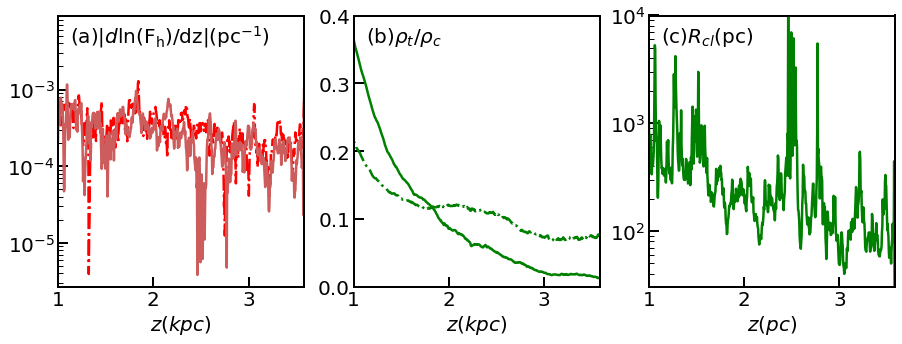

In [14]:

dlnFh = np.diff(np.log(Flux[2,:]))
dz  = np.diff(zaxis)
n0 = int ( 3584./deltaz)
Rcl = 0.75 * (Density[0,:-1]/density[0,:-1])/ abs(dlnFh/dz)


from matplotlib.ticker import MultipleLocator

#color = ['green', 'orange', 'red','black']
#label =[r'warm','intermediate', r'hot',r'all'] 

f, ax = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    ax[i].set_xlim(1.,3.584)
    ax[i].set_xticks(np.arange(1.0,3.584, 1.))

ax[0].plot(abs(zaxis[:n0])/1.e3,abs(dlnFh[:n0]/dz[:n0]), ls='-.',linewidth=2.5, label='z<0', color='red')
ax[0].plot(zaxis[n0:]/1.e3,abs(dlnFh[n0-1:]/dz[n0-1:]),ls='-', linewidth=2.5, label = 'z>0', color='indianred')
ax[0].set_yscale('log')
ax[0].set_xlabel("$z(kpc)$")

ax[1].plot(abs(zaxis[:n0])/1.e3,Density[0,:n0]/density[0,:n0], ls='-.',linewidth=2.5, color='green')
ax[1].plot(zaxis[n0:]/1.e3,Density[0,n0:]/density[0,n0:],ls='-',linewidth=2.5, color='green')
ax[1].legend()
ax[1].set_xlabel("$z(kpc)$")
ax[1].set_yticks(np.arange(0.0, 0.5, 0.1))
leg = ax[1].legend()
ax[1].set_ylim(0,0.4)
leg.get_frame().set_linewidth(0.0)


ax[2].plot(zaxis[n0:]/1.e3,Rcl[n0-1:],ls='-',linewidth=2.5, color='green')
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel("$z(pc)$")
ax[2].set_ylim(30.,1.e4)
leg = ax[2].legend()

leg.get_frame().set_linewidth(0.0)

for ax_,plabel in zip(ax,[r'(a)|$d\rm{ln}(F_{h})/dz|$(pc$^{-1}$)',r'(b)$\rho_t/\rho_c$', r'(c)$R_{cl}$(pc)']):
    ax_.text(0.05,0.9,plabel,transform=ax_.transAxes)


plt.savefig("../figures/dlnFh_volfrac_rcl.pdf", bbox='tight',dpi=150)